In [1]:
import os
import pandas as pd
import numpy as np
import time
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas.tseries.offsets import Second
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


def data_read(data_path,keyword):
    """
    :param data_path: file need to read
    :return:
    """
    files = os.listdir(data_path)  # 得到文件夹下的所有文件名称

    coal_machine = {}
    for coal_machine_path in files:  # 遍历文件夹
        if keyword in coal_machine_path:
            print("正在读取 " + coal_machine_path + " 数据。")

            coal_machine_files = os.listdir(data_path + "/" + coal_machine_path)

            one_coal_machine_pd = pd.DataFrame()  # 单台数据存储到一个DateFrame里面。
            for coal_machine_file in coal_machine_files:
                one_file_pd = read_data_from_file(data_path + "/" + coal_machine_path + "/" + coal_machine_file)
                one_coal_machine_pd = pd.concat([one_file_pd, one_coal_machine_pd])

            machine_name = coal_machine_path[coal_machine_path.find(keyword):coal_machine_path.find(keyword)+4]
            coal_machine[machine_name] = one_coal_machine_pd

    return coal_machine


def read_data_from_file(file_path):
    """
    :param file_path: the file which need to read by line
    :return: file line DataFrame
    """
    file_lines = list()

    file = open(file_path)
    for line in file:
        file_lines.append([line.split()[0] + ' ' + line.split()[1], line.split()[2]])
    file.close()

    file_lines_pd = pd.DataFrame(file_lines,columns=['DateTime', 'coal_value'])
    file_lines_pd['DateTime'] = pd.to_datetime(file_lines_pd['DateTime'], format='%Y-%m-%d %H:%M:%S')
    file_lines_pd.sort_values("DateTime", inplace=True)
    
    return file_lines_pd

def get(data):
    "对分段时间内的煤量进行累加"
    sum1=0
    for j in range(0,len(data)):
        sum1+=float(data['coal_value'][j])
        
    return sum1


def timeline(batchdata):
    "对每个给煤机中时间分段进行累加"
    generator3={}
    for key in batchdata:
        data_small_batch=batchdata[key]
        data_small_batch.sort_values("DateTime", inplace=True) 
        data_small_batch=data_small_batch.reset_index(drop=True) # 重新定义索引
        frequency = 300
        batch_sum1=list()
        batch_sum1.append(0)  #前一个月到下一个月初始值设为0
        year=data_small_batch['DateTime'][0].year
        month=data_small_batch['DateTime'][0].month
        day= data_small_batch['DateTime'][0].day
        start=str(year)+'-'+str(month)+'-'+str(day)+' '+'00:00:00'
        time_range = pd.date_range(start, data_small_batch['DateTime'][data_small_batch.shape[0]-1]+frequency*Second(),freq='%sS'%frequency)
        batch_df_date = data_small_batch.set_index('DateTime')
        for i in range(0, len(time_range) - 1):
            sum=get(batch_df_date.loc[time_range[i]:time_range[i + 1]])
            batch_sum1.append(sum) 
        #print(batch_sum1)
        batch_data = pd.Series(batch_sum1,time_range)
        dict_data = {'DateTime':batch_data.index,'coal_value':batch_data.values}
        df_month = pd.DataFrame(dict_data)
        generator3[key]=df_month
        
    return generator3

def series_to_supervised(data,columns,n_in=1,n_out=1,dropnan=True):
    "将数据转化为时间序列值"
    n_vars=1 if type(data)is list else data.shape[1]
    df=pd.DataFrame(data)
    cols,names=list(),list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names+=[('%s%d(t-%d)'%(columns[j],j + 1,i))for j in range(n_vars)]
    #序列(t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names+=[('%s%d(t)'%(columns[j],j + 1))for j in range(n_vars)]
        else:
            names+=[('%s%d(t+%d)'%(columns[j],j + 1,i))for j in range(n_vars)]
    agg=pd.concat(cols,axis=1)
    agg.columns=names
    if dropnan:
        clean_agg=agg.dropna()
        
    return clean_agg

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

我实在是太菜了。
#1炉数据
	B310090
正在读取 #1炉给煤机A数据 数据。
正在读取 #1炉给煤机B数据 数据。
正在读取 #1炉给煤机C数据 数据。
正在读取 #1炉给煤机D数据 数据。
正在读取 #1炉给煤机E数据 数据。
#2炉数据
	B310091
正在读取 #2炉给煤机A数据 数据。
正在读取 #2炉给煤机B数据 数据。
正在读取 #2炉给煤机C数据 数据。
正在读取 #2炉给煤机D数据 数据。
正在读取 #2炉给煤机E数据 数据。
#3炉数据
	B310519
正在读取 #3炉给煤机A数据 数据。
正在读取 #3炉给煤机B数据 数据。
正在读取 #3炉给煤机C数据 数据。
正在读取 #3炉给煤机D数据 数据。
正在读取 #3炉给煤机E数据 数据。
#4炉数据
	B310520
正在读取 给煤机A 数据。
正在读取 给煤机B 数据。
正在读取 给煤机C 数据。
正在读取 给煤机D 数据。
正在读取 给煤机E 数据。
#5炉数据
	B310796
正在读取 给煤机A 数据。
正在读取 给煤机B 数据。
正在读取 给煤机C 数据。
正在读取 给煤机D 数据。
正在读取 给煤机E 数据。
正在读取 给煤机F 数据。
#6炉数据
	B310830
正在读取 给煤机A 数据。
正在读取 给煤机B 数据。
正在读取 给煤机C 数据。
正在读取 给煤机D 数据。
正在读取 给煤机E 数据。
正在读取 给煤机F 数据。
#1炉数据
	B310090
正在读取 #1炉负荷数据 数据。
#2炉数据
	B310091
正在读取 #2炉负荷数据 数据。
#3炉数据
	B310519
正在读取 #3炉负荷数据 数据。
#4炉数据
	B310520
正在读取 负荷 数据。
#5炉数据
	B310796
正在读取 负荷 数据。
#6炉数据
	B310830
正在读取 负荷 数据。
已经读取完成1炉数据
已经读取完成2炉数据
已经读取完成3炉数据
已经读取完成4炉数据
已经读取完成5炉数据
已经读取完成6炉数据
已经完成负荷的去重
已经完成整体数据的时间序列划分
已经完成数据的异常值填充工作
Train on 6913 samples, validate on 1727 samples
Epoch 1/60
 - 1s - loss: 0.1419 - val_loss: 0.

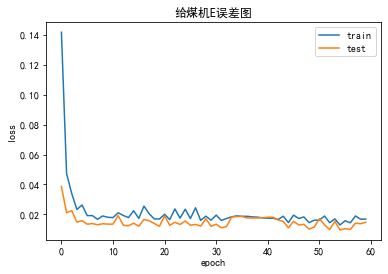

Test RMSE: 22.932
Train on 6913 samples, validate on 1727 samples
Epoch 1/60
 - 1s - loss: 0.0010 - val_loss: 8.3614e-04
Epoch 2/60
 - 0s - loss: 3.4402e-04 - val_loss: 1.3610e-04
Epoch 3/60
 - 0s - loss: 3.8290e-04 - val_loss: 3.5975e-05
Epoch 4/60
 - 0s - loss: 3.5196e-04 - val_loss: 1.5915e-05
Epoch 5/60
 - 0s - loss: 2.7056e-04 - val_loss: 3.4232e-04
Epoch 6/60
 - 0s - loss: 3.3508e-04 - val_loss: 3.5005e-04
Epoch 7/60
 - 0s - loss: 2.6382e-04 - val_loss: 3.2635e-05
Epoch 8/60
 - 0s - loss: 1.7685e-04 - val_loss: 3.2782e-05
Epoch 9/60
 - 0s - loss: 2.6949e-04 - val_loss: 1.0808e-04
Epoch 10/60
 - 0s - loss: 1.6734e-04 - val_loss: 1.1741e-04
Epoch 11/60
 - 0s - loss: 1.5423e-04 - val_loss: 3.6440e-04
Epoch 12/60
 - 0s - loss: 1.8185e-04 - val_loss: 1.1341e-04
Epoch 13/60
 - 0s - loss: 1.9098e-04 - val_loss: 2.6668e-04
Epoch 14/60
 - 0s - loss: 1.2621e-04 - val_loss: 4.0215e-05
Epoch 15/60
 - 0s - loss: 1.3402e-04 - val_loss: 1.7648e-06
Epoch 16/60
 - 0s - loss: 1.1490e-04 - val_loss

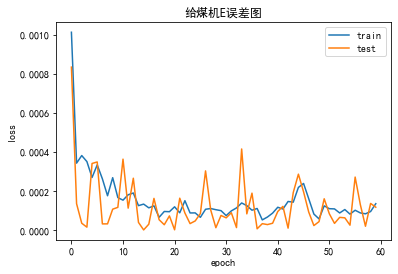

Test RMSE: 0.064
Train on 6913 samples, validate on 1727 samples
Epoch 1/60
 - 1s - loss: 0.0011 - val_loss: 3.9505e-05
Epoch 2/60
 - 0s - loss: 6.3460e-04 - val_loss: 7.7452e-04
Epoch 3/60
 - 0s - loss: 6.8887e-04 - val_loss: 1.4381e-04
Epoch 4/60
 - 0s - loss: 0.0011 - val_loss: 7.9432e-04
Epoch 5/60
 - 0s - loss: 7.5765e-04 - val_loss: 0.0013
Epoch 6/60
 - 0s - loss: 8.2717e-04 - val_loss: 4.9584e-04
Epoch 7/60
 - 0s - loss: 7.2754e-04 - val_loss: 6.5789e-04
Epoch 8/60
 - 0s - loss: 7.9663e-04 - val_loss: 0.0010
Epoch 9/60
 - 0s - loss: 5.1967e-04 - val_loss: 3.6263e-04
Epoch 10/60
 - 0s - loss: 8.0618e-04 - val_loss: 0.0012
Epoch 11/60
 - 0s - loss: 8.3879e-04 - val_loss: 5.6885e-04
Epoch 12/60
 - 0s - loss: 9.5568e-04 - val_loss: 0.0019
Epoch 13/60
 - 0s - loss: 9.8828e-04 - val_loss: 6.0028e-04
Epoch 14/60
 - 0s - loss: 8.3524e-04 - val_loss: 3.8876e-04
Epoch 15/60
 - 0s - loss: 6.1440e-04 - val_loss: 8.5376e-04
Epoch 16/60
 - 0s - loss: 7.5977e-04 - val_loss: 2.9555e-04
Epoch 17

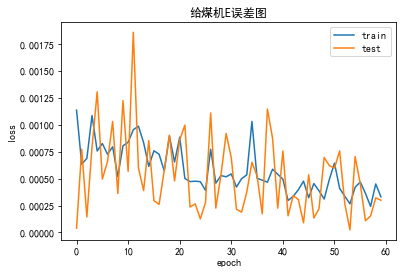

Test RMSE: 0.089
Train on 6913 samples, validate on 1727 samples
Epoch 1/60
 - 1s - loss: 0.1566 - val_loss: 0.0296
Epoch 2/60
 - 0s - loss: 0.0445 - val_loss: 0.0326
Epoch 3/60
 - 0s - loss: 0.0398 - val_loss: 0.0292
Epoch 4/60
 - 0s - loss: 0.0339 - val_loss: 0.0183
Epoch 5/60
 - 0s - loss: 0.0312 - val_loss: 0.0164
Epoch 6/60
 - 0s - loss: 0.0269 - val_loss: 0.0171
Epoch 7/60
 - 0s - loss: 0.0259 - val_loss: 0.0192
Epoch 8/60
 - 0s - loss: 0.0229 - val_loss: 0.0202
Epoch 9/60
 - 0s - loss: 0.0236 - val_loss: 0.0199
Epoch 10/60
 - 0s - loss: 0.0238 - val_loss: 0.0287
Epoch 11/60
 - 0s - loss: 0.0287 - val_loss: 0.0425
Epoch 12/60
 - 0s - loss: 0.0278 - val_loss: 0.0209
Epoch 13/60
 - 0s - loss: 0.0216 - val_loss: 0.0412
Epoch 14/60
 - 0s - loss: 0.0235 - val_loss: 0.0257
Epoch 15/60
 - 0s - loss: 0.0248 - val_loss: 0.0356
Epoch 16/60
 - 0s - loss: 0.0256 - val_loss: 0.0307
Epoch 17/60
 - 0s - loss: 0.0255 - val_loss: 0.0203
Epoch 18/60
 - 0s - loss: 0.0218 - val_loss: 0.0290
Epoch 19

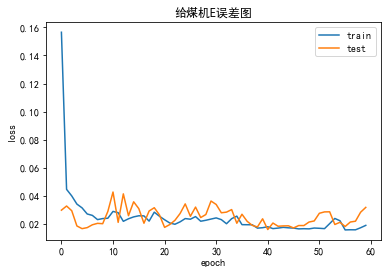

Test RMSE: 60.358
Train on 110593 samples, validate on 27647 samples
Epoch 1/60
 - 5s - loss: 0.0426 - val_loss: 0.0280
Epoch 2/60
 - 4s - loss: 0.0191 - val_loss: 0.0136
Epoch 3/60
 - 4s - loss: 0.0105 - val_loss: 0.0096
Epoch 4/60
 - 4s - loss: 0.0087 - val_loss: 0.0087
Epoch 5/60
 - 4s - loss: 0.0087 - val_loss: 0.0089
Epoch 6/60
 - 4s - loss: 0.0086 - val_loss: 0.0156
Epoch 7/60
 - 4s - loss: 0.0086 - val_loss: 0.0161
Epoch 8/60
 - 4s - loss: 0.0086 - val_loss: 0.0080
Epoch 9/60
 - 4s - loss: 0.0087 - val_loss: 0.0078
Epoch 10/60
 - 4s - loss: 0.0086 - val_loss: 0.0072
Epoch 11/60
 - 4s - loss: 0.0082 - val_loss: 0.0145
Epoch 12/60
 - 5s - loss: 0.0087 - val_loss: 0.0111
Epoch 13/60
 - 5s - loss: 0.0081 - val_loss: 0.0070
Epoch 14/60
 - 4s - loss: 0.0086 - val_loss: 0.0083
Epoch 15/60
 - 5s - loss: 0.0084 - val_loss: 0.0064
Epoch 16/60
 - 5s - loss: 0.0081 - val_loss: 0.0127
Epoch 17/60
 - 4s - loss: 0.0083 - val_loss: 0.0097
Epoch 18/60
 - 4s - loss: 0.0083 - val_loss: 0.0092
Epoc

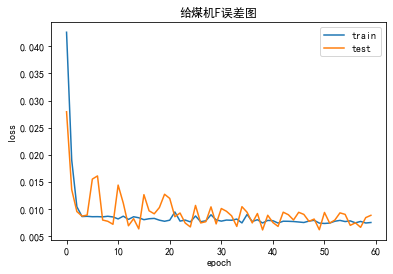

Test RMSE: 44.448
Train on 6913 samples, validate on 1727 samples
Epoch 1/60
 - 1s - loss: 0.1230 - val_loss: 0.0104
Epoch 2/60
 - 0s - loss: 0.0536 - val_loss: 0.0147
Epoch 3/60
 - 0s - loss: 0.0525 - val_loss: 0.0138
Epoch 4/60
 - 0s - loss: 0.0516 - val_loss: 0.0118
Epoch 5/60
 - 0s - loss: 0.0440 - val_loss: 0.0115
Epoch 6/60
 - 0s - loss: 0.0431 - val_loss: 0.0158
Epoch 7/60
 - 0s - loss: 0.0429 - val_loss: 0.0149
Epoch 8/60
 - 0s - loss: 0.0362 - val_loss: 0.0143
Epoch 9/60
 - 0s - loss: 0.0338 - val_loss: 0.0134
Epoch 10/60
 - 0s - loss: 0.0302 - val_loss: 0.0137
Epoch 11/60
 - 0s - loss: 0.0264 - val_loss: 0.0137
Epoch 12/60
 - 0s - loss: 0.0257 - val_loss: 0.0180
Epoch 13/60
 - 0s - loss: 0.0285 - val_loss: 0.0147
Epoch 14/60
 - 0s - loss: 0.0219 - val_loss: 0.0142
Epoch 15/60
 - 0s - loss: 0.0241 - val_loss: 0.0134
Epoch 16/60
 - 0s - loss: 0.0218 - val_loss: 0.0131
Epoch 17/60
 - 0s - loss: 0.0245 - val_loss: 0.0111
Epoch 18/60
 - 0s - loss: 0.0232 - val_loss: 0.0106
Epoch 1

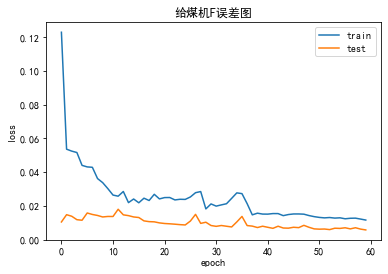

Test RMSE: 20.189


In [3]:
if __name__ == '__main__':
    """读取全部数据，包括给煤量与负荷值"""
    print("我实在是太菜了。")
    path = "C:/Users/fangjianwen/Desktop/ft2020/ori_data/#1炉数据/B310090"  # 文件夹目录
    data_str = "C:/Users/fangjianwen/Desktop/ft2020/ori_data"
    generator = {}
    eletronic={}
    generator1={}
    electronic1 = {}
    generator2={}
    data_all={}
    for path_i in os.listdir(data_str):
        print(path_i)
        generator_name = path_i[path_i.find("炉") - 1:path_i.find("炉") + 1]
        for path_j in os.listdir(data_str + "/" + path_i):
            print("\t" + path_j)
            generator[generator_name] = data_read(data_str + "/" + path_i + "/" + path_j,"给煤机")
    for path_i in os.listdir(data_str):
        print(path_i)
        eletronic_name = path_i[path_i.find("炉") - 1:path_i.find("炉") + 1]
        for path_j in os.listdir(data_str + "/" + path_i):
            print("\t" + path_j)
            eletronic[eletronic_name] =data_read(data_str + "/" + path_i + "/" + path_j,"负荷")
    """分别求出每个炉中每个型号给煤机在时间段上的量"""        
    for bar in generator:
        batch_data=timeline(generator[bar]) 
        generator2[bar]=batch_data
        print("已经读取完成"+bar+"数据")
    """将全部的负荷数据进行去重工作"""
    for batch1 in eletronic:
        #print(eletronic[batch1])
        batch1_df=pd.DataFrame()
        for key, value in eletronic[batch1].items():
            batch1_df=pd.concat([batch1_df,value],axis=0) 
        batch1_df.sort_values("DateTime", inplace=True)
        batch_df= batch1_df.reset_index(drop=True) # 重新定义索引
        batch_df_sum=batch_df.drop_duplicates()
        batch_df_sum= batch_df_sum.reset_index(drop=True) # 重新定义索引
        batch_df_sum1=batch_df_sum.replace(batch_df_sum.iloc[0]['coal_value'],0)
        #print(batch_df_sum1)
        electronic1[batch1]=batch_df_sum1
    print("已经完成负荷的去重")
    """对每个炉中的数据进行时间序列分段求和"""
    for batch in generator:
        batch_df=pd.DataFrame(data=None,columns=['DateTime', 'coal_value'])
        for key, value in generator[batch].items():
            batch_df=pd.concat([batch_df,value],axis=0)
        batch_df.sort_values("DateTime", inplace=True) 
        batch_df= batch_df.reset_index(drop=True) # 重新定义索引
        #print(batch_df)
        frequency = 300
        batch_sum=list()
        batch_sum.append(0)  #前一个月到下一个月初始值设为0
        year=batch_df['DateTime'][0].year
        month=batch_df['DateTime'][0].month
        day= batch_df['DateTime'][0].day
        start=str(year)+'-'+str(month)+'-'+str(day)+' '+'00:00:00'
        time_range = pd.date_range(start, batch_df['DateTime'][batch_df.shape[0]-1]+frequency*Second(),freq='%sS'%frequency)
        #print(time_range)
        batch_df_date = batch_df.set_index('DateTime')
        for i in range(0, len(time_range) - 1):
            sum=get(batch_df_date.loc[time_range[i]:time_range[i + 1]])
            batch_sum.append(sum) 
        #print(batch_sum)
        batch_data = pd.Series(batch_sum,time_range)
        dict_data = {'DateTime':batch_data.index,'coal_value':batch_data.values}
        df_month = pd.DataFrame(dict_data)
        generator1[batch]=df_month
    print("已经完成整体数据的时间序列划分")
    """进行数据的填充工作"""
    for key in electronic1:
        data1=generator1[key]
        data2=electronic1[key]
        data1= data1.set_index(['DateTime']) # 重新定义索引
        data2= data2.set_index(['DateTime']) # 重新定义索引
        data=pd.merge(data1,data2,left_on='DateTime',right_index=True,how='outer')
        dataall=data[data.isnull().values==True]
        #print(dataall)
        data_all[key]=data.fillna(method='ffill')
    print("已经完成数据的异常值填充工作")
    """进行数据的融合，并且放到LSTM模型进行训练"""
    for bar in generator2:
        merge_one=data_all[bar]
        merge_one.columns=[bar,'负荷']
        for key,value in generator2[bar].items():
            datai= value.set_index(['DateTime']) # 重新定义索引
            datai.columns=[key]
            merge_one=pd.merge(datai,merge_one,left_on='DateTime',right_index=True,how='outer')
        dataset_columns =merge_one.columns
        label=len(dataset_columns)
        drop_label=list(range(label,2*label-1))
        reframed = series_to_supervised(merge_one, dataset_columns, 1, 1)
        reframed.drop(reframed.columns[drop_label], axis=1, inplace=True)
        #print(reframed)
        value = reframed.values  
        scaler = MinMaxScaler(feature_range=(0, 1)) # 对数据进行归一化处理
        scaled = scaler.fit_transform(value)
        values=scaled
        n_train_hours =round(len(merge_one)*0.8)
        train = values[:n_train_hours, :]
        test = values[n_train_hours:, :]
        train_x, train_y = train[:, :-1], train[:, -1]
        test_x, test_y = test[:, :-1], test[:, -1]
        train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
        test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
        #训练模型
        model = Sequential()
        model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=60, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False 
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.title(bar+"误差图")
        plt.show()
        yHat = model.predict(test_X)
        inv_yHat = concatenate((yHat,test_x), axis=1)   # 数组拼接
        inv_yHat = scaler.inverse_transform(inv_yHat)
        inv_yHat = inv_yHat[:, 0]
        test_y = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y,test_x), axis=1)
        inv_y = scaler.inverse_transform(inv_y)    # 将标准化的数据转化为原来的范围
        inv_y = inv_y[:, 0]
        rmse = sqrt(mean_squared_error(inv_yHat, inv_y))
        print('Test RMSE: %.3f' % rmse)